# Loading data

Image data acquired in microscopy are stored in various formats: TIF, LSM, CZI, LIF, ND2 We'll use the imageanalysis kernel we have created earlier and we assume here that we are working in the example folder ( use %cd in the notebook to change directory ).

Some image reader will return a numpy array which represents array of values on a regular grid. Other might return a Pillow object representing an image object. We may need to convert the multi-frame/slice/channel dataset into a multi-dimensional array (see LIF files).


In [ ]:
# In this cell we'll download and unzip the example data set
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

url = 'https://cloud.mrc-lmb.cam.ac.uk/s/crKayCH6YfTGccq/download'

download_and_unzip(url, '../data/')

## Loading TIF
For loading TIF images, we can use the module tifffile. It also supports LSM (Zeiss), OME-TIF, ImageJ hyperstacks, etc.
If installing modules manually, type in the prompt the command:  ```conda install tifffile```. Let's load the all content of the file into a numpy array:

The shape of the array is [depth x channels x height x width] (25, 2, 400, 400)


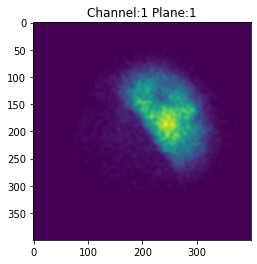

In [1]:
# We first load in python useful modules for loading and displaying images
import tifffile
import matplotlib.pyplot as plt
# Let's set the name of the file we want to open
filename = '../data/example.tif'

# We use the tifffile module to read the image from disk
img = tifffile.imread(filename)

# Let's check the shape/size of the image (note the order of the planes)
print("The shape of the array is [depth x channels x height x width]", img.shape)

# We select the middle plane and the second channel (indices starts at 0)
middle_plane_index = round(img.shape[1] / 2)
plane = img[middle_plane_index,1,:,:]
plt.imshow(plane)
plt.title('Channel:{ch} Plane:{z}'.format(ch=1,z=middle_plane_index))
plt.show()

## Nikon ND2 files
Nikon ND2 files can be loaded using the python module nd2reader (https://rbnvrw.github.io/nd2reader/). The module is available on the channel conda-forge. Add the conda-forge channel using the following command: ```conda install -c conda-forge nd2reader```. Now we can read an image from ND2 files using:

Image size: {'x': 1952, 'y': 1952, 'c': 3, 't': 1}


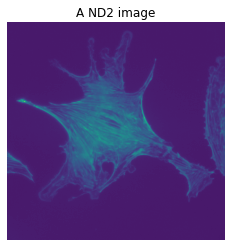

In [3]:
# We load first the nd2reader module
from nd2reader import ND2Reader
import matplotlib.pyplot as plt

# We are creating a reader for the nd2 image
with ND2Reader('../data/example.nd2') as images:
  
  # Let's print out the image size
  print('Image size:', images.sizes)
  
  # We define the axis on which we iterate the 2D planes
  images.iter_axes = 'c'

  # Let finally show the 2nd channel of the image
  plt.imshow(images[1])
  plt.title('A ND2 image')
  plt.axis('off')

## Leica LIF files
For Leila LIF files we can use readlif https://pypi.org/project/readlif/ . This module needs to be installed using pip instead of conda using 
```pip install readlif```. We use the function get_frame from readlif to get a Pillow 2D image:

There are 27 images in ../data/example.lif
Imagewith index 3 has dimensions: Dims(x=4688, y=4688, z=1, t=1, m=1)


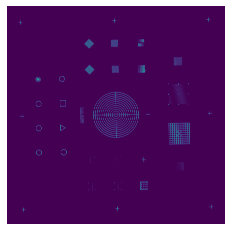

In [4]:
# Let's load the reader from the readlif module
from readlif.reader import LifFile
import matplotlib.pyplot as plt
import numpy as np

# We create an object containing the image data
filename = '../data/example.lif'
lif = LifFile(filename)

# Let count the number of data sets in the file
print(f"There are {lif.num_images} images in {filename}")

# Let's get the first image
index = 3
img = lif.get_image(index)
print(f"Imagewith index {index} has dimensions: {img.dims}")

# We extract a 2D frame from the image, the frame is a PIL image object
frame = img.get_frame(z=0,t=0,m=0)

# And finally display the 2D PIL image, note that PIL images can also be directly
# displayed in the notebook.
plt.imshow(frame)
plt.axis('off')
plt.show()

Now we may want to gather all image frames into a single numpy array:

In [ ]:
# Load the all stack in a numpy array
M = np.zeros((img.dims.z,img.dims.y,img.dims.x))
for k in range(img.dims.z):
    M[k,:,:] = img.get_frame(z=k,t=0,m=0)

print("The shape of the numpy array is", M.shape)

# We can display a slice of the array using numpy
plt.imshow(M[5,:,:])

## Zeiss CZI files
Another format that you may encounter for data acquired in Zeiss microscopes is the CZI file format. 

You can install the czifile module using ```conda install -y -c conda-forge czifile```. Let's open now a CZI file using the czifile module.

The module gives access to an multi-dimensional numpy array.

Shape of the array : (1, 2, 1, 1, 1024, 1024, 1)


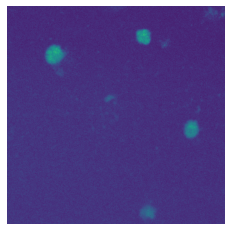

In [6]:
import czifile

image =  czifile.imread('../data/example.czi')
print("Shape of the array :" , image.shape)

plt.imshow(image[0,0,0,0,:,:,0])
plt.axis('off')
plt.show()

We can also use the module from the Allen Institute: aicspylibczi based on libczi from Zeiss. For this we need to install it with ```pip install  aicspylibczi ```

Size of the image  (1, 1, 2, 1, 1024, 1024)


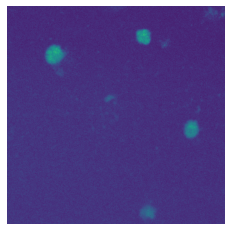

In [7]:
import numpy as np
from aicspylibczi import CziFile
from pathlib import Path
import matplotlib.pyplot as plt

pth = Path('../data/example.czi')
czi = CziFile(pth)
print("Size of the image ", czi.size)
img, shp = czi.read_image()
plt.imshow(img[0,0,0,0,:,:])
plt.axis('off')
plt.show()

## Using bioformat
Bioformat-python enable to load most image format using javabridge and bioformat. We can install bioformat-python with pip but you'll need to install Oracle JDK 1.6 or later first (https://www.oracle.com/uk/java/technologies/javase-jdk15-downloads.html) and install the module using ``` pip install python-bioformat ```. This approach might be unstable than using the dedicated image readers but provides an uniform access to various file formats.

Now let's open an image using bioformat. We need to start a virtual machine first and not forget to stop it when finished.

In [ ]:
import javabridge
import bioformats 

javabridge.start_vm(class_path=bioformats.JARS)
img = bioformats.load_image('../data/example.tif', c=0, z=0, t=0)
javabridge.kill_vm()
plt.imshow(img)

### Imaris HDF5
HDF5 is a hierarchical fileformat that is used by imaris for example (IMS). 
[https://github.com/imaris/ImarisWriter/blob/master/doc/Imaris5FileFormat.pdf] and [https://github.com/imaris/ImarisWriter]

For 8bit datasets, Imaris expect a file with the following data structure 
- DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data (as 8bit unsigned int)
- DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Histogram (as 64bit float)
 Each 'Channel x' group will have the following attributes: ImageSizeX,ImageSizeY, ImageSizeZ, HistogramMax, HistogramMin.   

For 16bit dataset, we have instead:
- DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data (as 8bit unsigned int)
- DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Histogram1024 (as 64bit float)
 Each 'Channel x' group will have the following attributes: ImageSizeX,ImageSizeY, ImageSizeZ, HistogramMax1024, HistogramMin1024.   

 - DataSetInfo/Image with attributes ExtMin0 ExtMin1 ExtMin2 ExtMax0...

In [16]:
# Load a tif file to export to hdf5 as a numpy array [z,c,x,y]
img = tifffile.imread( '../data/example.tif')

# extract the first channel
stack = np.squeeze(img[:,0,:,:])
print(f'The stack size is {stack.shape} with type {stack.dtype}')

def ims_create_channel(f, stack, resolution, timepoint, channel):
    # compute the histogram of the image
    [histogram, bin_edges] = np.histogram(stack.ravel(),bins=256)
    grp = f.create_group(f'DataSet/ResolutionLevel {resolution}/TimePoint {timepoint}/Channel {channel}')
    grp.attrs['ImageSizeX'] = img.shape[2]
    grp.attrs['ImageSizeY'] = img.shape[3]
    grp.attrs['ImageSizeZ'] = img.shape[0]
    grp.attrs['HistogramMax'] = bin_edges[255]
    grp.attrs['HistogramMin'] = bin_edges[0]
    f['DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data'] = stack
    f['DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Histogram'] = histogram
    # We add the DataSetInfo/Channel 0 group to store color info on the channel
    grp = f.create_group('DataSetInfo/Channel 0')
    grp.attrs['Color'] = '1.000 0.000 0.000' # RGB triplet between 0-1 as a string
    grp.attrs['ColorMode'] = 'BaseColor' # 'BaseColor' or 'ColorTable'
    grp.attrs['ColorOpacity'] = '0.500' # between 0-1 as a string with 3 decimal 
    grp.attrs['ColorRange'] = '0 255' # color range rendered in imaris

def ims_set_image_info(f,shape):
    grp = f.create_group('DataSetInfo/Image')
    grp.attrs['ExtMin0'] = 0
    grp.attrs['ExtMin1'] = 0
    grp.attrs['ExtMin2'] = 0
    grp.attrs['ExtMax0'] = shape[2] # maximum x coordinate
    grp.attrs['ExtMax1'] = shape[1] # maximum y coordinate
    grp.attrs['ExtMax2'] = shape[0] # maximum y coordinate

with h5py.File('../scratch/example.hdf5', 'w') as f:
    # We add the DataSetInfo/Image group
    ims_set_image_info(f, stack.shape)
    ims_create_channel(f, stack, 0, 0, 0)

The stack size is (25, 400, 400) with type uint8


Let's check the content of the file we just created. For this, we create a dump function that explores the HDF5 tree of groups and datasets printing attributes when needed. 

In [17]:
import h5py

def h5dump(obj,sep='  '):
    '''
    Dump the content of the HDF5 file
    '''
    # Print attributes of the group/dataset
    for akey in obj.attrs.keys():
        print(f'{sep}   > {akey} : {obj.attrs[akey]}')
    # Go down the tree
    if type(obj) in [h5py._hl.group.Group, h5py._hl.files.File]:
        for key in obj.keys():
            print(f'{sep} - {key}')
            h5dump(obj[key],sep+'  ')

with h5py.File('../scratch/example.hdf5','r') as f:
    h5dump(f)

   - DataSet
     - ResolutionLevel 0
       - TimePoint 0
         - Channel 0
             > HistogramMax : 252.01171875
             > HistogramMin : 0.0
             > ImageSizeX : 400
             > ImageSizeY : 400
             > ImageSizeZ : 25
           - Data
           - Histogram
   - DataSetInfo
     - Channel 0
         > Color : 1.000 0.000 0.000
         > ColorMode : BaseColor
         > ColorOpacity : 0.500
         > ColorRange : 0 255
     - Image
         > ExtMax0 : 400
         > ExtMax1 : 400
         > ExtMax2 : 25
         > ExtMin0 : 0
         > ExtMin1 : 0
         > ExtMin2 : 0


### Big Data viewer

To read and write HDF5 file compatible with the big data viewer, we can use the module npy2bdv which can be installed using pip: ```pip install npy2bdv```. We'll see some basic functionality, more can be found here [[https://github.com/nvladimus/npy2bdv/blob/master/docs/examples/examples_h5writing.ipynb]].

In [21]:
import numpy as np
import npy2bdv

# We use the tifffile module to read the image from disk
img = tifffile.imread( '../data/example.tif')
# lets set the output filename
fname = "../scratch/example2.h5"
# we create a writer object with 2 channels
bdv_writer = npy2bdv.BdvWriter(fname, nchannels=2)
# set the attributes
bdv_writer.set_attribute_labels('channel', ('488', '561'))

for channel in range(2):
    bdv_writer.append_view(np.squeeze(img[:,channel,:,:]), channel=channel)

bdv_writer.write_xml_file()
bdv_writer.close()

FileExistsError: File ../scratch/example2.h5 already exists.

We can use h5py to dump the content of this file as well:

In [22]:
with h5py.File('../scratch/example2.h5','r') as f:
    h5dump(f)

   - s00
     - resolutions
     - subdivisions
   - s01
     - resolutions
     - subdivisions
   - t00000
     - s00
       - 0
         - cells
     - s01
       - 0
         - cells


Let's load the image we just created : 

In [23]:
bdv_editor = npy2bdv.BdvEditor(fname)
stack = bdv_editor.read_view(channel=0)
print(stack.shape)

AssertionError: Error: ../scratch/example2.xml file not found

## Zarr file format
We may want to convert the dataset to a parallel file format such as zarr for performance. A parallel file format enable loading and decoding chunks in parallel. If the underlying hardware is not parallel (HDD) then this has limited interest. On the other hand, on a LUSTRE [https://en.wikipedia.org/wiki/Lustre_(file_system)], the file server is tuned to large files and overhead will occur when splitting the file in small chunks.

In [ ]:
import tifffile
import numpy as np
import zarr
from numcodecs import Blosc

# We use the tifffile module to read the image from disk into a numpy array
img = tifffile.imread( '../data/example.tif')

# By default zarr creates a directory with many files corresponding to data chunk
zarr.save('../scratch/example.zarr', img)

# We can also define a zip store to store all the files in a single zip file
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
with zarr.ZipStore('../scratch/array.zip', mode='w') as store:
    z = zarr.array(img, chunck=(128,128), compressor=compressor, store = store)

We can now load a part of a plane of the image into memory. We can use this approach for example to load specific frames of a time lapse sequence sparing the memory.

In [24]:
z1 = zarr.open('../scratch/array.zip', mode='r')
plt.imshow(z1[12,0,0:200,0:200])
plt.axis('off')
plt.show()

NameError: name 'zarr' is not defined

In [ ]:
## Image pyramid

Image pyramid allow faster browsing of multi resolution images.

https://forum.image.sc/t/multiscale-arrays-v0-1/37930
[https://github.com/ome/ome-zarr-py/blob/master/ome_zarr/data.py]

In [ ]:
from skimage.transform import pyramid_gaussian, pyramid_laplacian
from scipy.ndimage import zoom
import zarr
from numcodecs import Blosc
import numpy as np

# We use the tifffile module to read the image from disk
img = tifffile.imread('../data/example.tif')

# create a pyramid with data shape as t, c, z, y, x
print(img.shape)
img = np.moveaxis(img, [0,1,2,3],[1,0,2,3])
img = np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2], img.shape[3]])
print(img.shape)

# pyramid = list(reversed([zoom(img, 2 ** i, order=3) for i in range(4)]))

list(reversed([ 2 ** i for i in range(4)]))

In [ ]:
from ome_zarr import data
p,l = data.coins()
data.create_zarr('../scratch/coins.zarr')

In [ ]:

store = zarr.DirectoryStore('../scratch/pyr.zarr') 
grp = zarr.group(store)
paths = []

for path, dataset in enumerate(pyramid):
    grp.create_dataset(str(path), data=pyramid[path])
    paths.append({"path": str(path)})

multiscales = [{"version": "0.1", "datasets": paths}]
grp.attrs["multiscales"] = multiscales
image_data = {
    "channels": [
        {
            "color": "FF0000",
            "window": {"start": 0, "end": 1},
            "label": "Red",
            "active": True,
        },
        {
            "color": "00FF00",
            "window": {"start": 0, "end": 1},
            "label": "Green",
            "active": True,
        }
    ],
    "rdefs": {"model": "color"},
}
grp.attrs["omero"] = image_data      
print(grp.info)